### In order to analyze and predict state legislative elections, one must understand the effects and trends that happen as voters descend the ballot. One key metric that we wish to understand is the ratio between the dropoff in Democratic votes against the dropoff of turnout. After adjusting for the average of this ratio (in the given election year), we get a decent proxy for campaign quality, as candidates with higher ratios indicate higher efficency in capturing the vote. 

### This repository contains a number of scripts to pull and aggregate Michigan's election and campaign finance data. Our goal is to use data from previous cycles to predict the future dropoff ratio. What follows is a simple example that describes the problem.

### We begin by pulling the aggregated election data from the public google sheets url and turning it into a pandas dataframe.

In [9]:
import pandas as pd
import io
import requests
url="https://docs.google.com/spreadsheets/d/e/2PACX-1vQ3PJo7MypccsND1j5w4f_iU2bnkTdSo5v1-hteTE-UiCNZTd7-N01cmXgPflxcVfGrZk7sX3VlDBno/pub?gid=1229300072&single=true&output=csv"
s=requests.get(url).content
df=pd.read_csv(io.StringIO(s.decode('utf-8')))

df.head()

election_year                                 office_description  \
0           2008  PRESIDENT OF THE UNITED STATES 4 YEAR TERM (1)...   
1           2008     UNITED STATES SENATOR 6 YEAR TERM (1) POSITION   
2           2008  1ST DISTRICT REPRESENTATIVE IN CONGRESS 2 YEAR...   
3           2008  2ND DISTRICT REPRESENTATIVE IN CONGRESS 2 YEAR...   
4           2008  3RD DISTRICT REPRESENTATIVE IN CONGRESS 2 YEAR...   

   office_code  district_code  dem_votes  total_votes  dem_percent  \
0            1              0    2872579      5001766     0.574313   
1            5              0    3038386      4848620     0.626650   
2            6            100     213216       327836     0.650374   
3            6            200     119506       343309     0.348100   
4            6            300     117961       333518     0.353687   

   previous_dem_votes  previous_turnout  previous_two_dem_votes  \
0                 NaN               NaN                     NaN   
1                 NaN               NaN                     NaN   
2                 NaN               NaN                     NaN   
3                 NaN               NaN                     NaN   
4                 NaN               NaN                     NaN   

       ...        next_two_dem_ratio  previous_turnout_ratio  \
0      ...                  1.266101                     NaN   
1      ...                  1.782111                     NaN   
2      ...                  1.290818                     NaN   
3      ...                  1.096657                     NaN   
4      ...                  0.818560                     NaN   

   previous_two_turnout_ratio  next_turnout_ratio  next_two_turout_ratio  \
0                         NaN            1.059713               1.042190   
1                         NaN            1.044316               1.553161   
2                         NaN            1.412861               0.944672   
3                         NaN            1.505226               1.078682   
4                         NaN            1.488501               1.022174   

   highest_total_votes  highest_dem_votes  total_dt_dropoff  dem_dt_dropoff  \
0              5001766            2872579          1.000000        1.000000   
1              5001694            2872650          0.969396        1.057694   
2               333304             166472          0.983595        1.280792   
3               352852             167587          0.972955        0.713098   
4               346518             169274          0.962484        0.696864   

   dropoff_ratio  
0       1.000000  
1       1.091087  
2       1.302154  
3       0.732920  
4       0.724027  

[5 rows x 28 columns]

### As we only care about state house races, we filter to the races after redistricting (2012 on), and adjust our dropoff ratio against the mean (to reduce the effects of top-of-the-ticket candidate quality). 

In [26]:
import warnings
warnings.filterwarnings('ignore')

office_analysis = df.iloc[(df['election_year']>2010).values]
state_legislature = office_analysis.iloc[(office_analysis['office_code'] > 7).values]
state_legislature['previous_dem_percent'] = state_legislature['previous_dem_votes']/state_legislature['previous_turnout']
state_averages = state_legislature.groupby(['election_year','office_code'])['previous_dem_percent','dropoff_ratio'].apply(lambda x: x.mean())
state_legislature['adjusted_dropoff_ratio'] = state_legislature.apply(
    lambda x: x['dropoff_ratio']-state_averages['dropoff_ratio'][x['election_year']][x['office_code']],
    axis = 1
)
state_legislature['adjusted_previous_dem'] = state_legislature.apply(
    lambda x: x['previous_dem_percent']-state_averages['previous_dem_percent'][x['election_year']][x['office_code']],
    axis = 1
)
state_legislature.head()

election_year                                 office_description  \
560           2012  1ST DISTRICT STATE REPRESENTATIVE 2 YEAR TERM ...   
561           2012  1ST DISTRICT REPRESENTATIVE IN STATE LEGISLATU...   
562           2012  2ND DISTRICT STATE REPRESENTATIVE 2 YEAR TERM ...   
563           2012  2ND DISTRICT REPRESENTATIVE IN STATE LEGISLATU...   
564           2012  3RD DISTRICT REPRESENTATIVE IN STATE LEGISLATU...   

     office_code  district_code  dem_votes  total_votes  dem_percent  \
560            8            100      23639        34847     0.678365   
561            8            100      23639        34847     0.678365   
562            8            200      21823        31066     0.702472   
563            8            200      21823        31066     0.702472   
564            8            300      24473        25591     0.956313   

     previous_dem_votes  previous_turnout  previous_two_dem_votes  \
560             17718.0           32928.0                 26811.0   
561             17718.0           32928.0                 26811.0   
562             11320.0           11777.0                 25327.0   
563             11320.0           11777.0                 25327.0   
564             13200.0           14044.0                 27828.0   

             ...            next_turnout_ratio  next_two_turout_ratio  \
560          ...                      1.465761               0.954582   
561          ...                      1.465761               0.954582   
562          ...                      1.241002               0.878216   
563          ...                      1.241002               0.878216   
564          ...                      0.637734               0.861041   

     highest_total_votes  highest_dem_votes  total_dt_dropoff  dem_dt_dropoff  \
560                36651              27011          0.950779        0.875162   
561                36651              27011          0.950779        0.875162   
562                32500              24350          0.955877        0.896222   
563                32500              24350          0.955877        0.896222   
564                26414              26014          0.968842        0.940763   

     dropoff_ratio  previous_dem_percent  adjusted_dropoff_ratio  \
560       0.920468              0.538083               -0.061504   
561       0.920468              0.538083               -0.061504   
562       0.937591              0.961196               -0.044381   
563       0.937591              0.961196               -0.044381   
564       0.971017              0.939903               -0.010955   

     adjusted_previous_dem  
560               0.028570  
561               0.028570  
562               0.451683  
563               0.451683  
564               0.430391  

[5 rows x 31 columns]

### We plot the distribution of the adjusted dropoff ratio to find it to be normally distributed around zero.

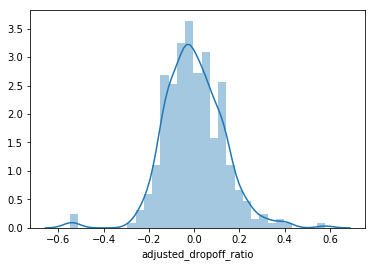

In [8]:
%matplotlib inline

import seaborn as sns

sns.distplot(state_legislature['adjusted_dropoff_ratio'])

### As an example model, we use the previous cycle's Dem competitiveness (i.e. the square distance from fifty percent) to construct a hierarchical model by year. We find this measure to have a bit of explanatory power, but is not enough to pass the credible interval in all years (it passed in 2014).

Average Loss = 249.05: 100%|██████████| 100000/100000 [01:18<00:00, 1279.60it/s]
Finished [100%]: Average Loss = 249.05


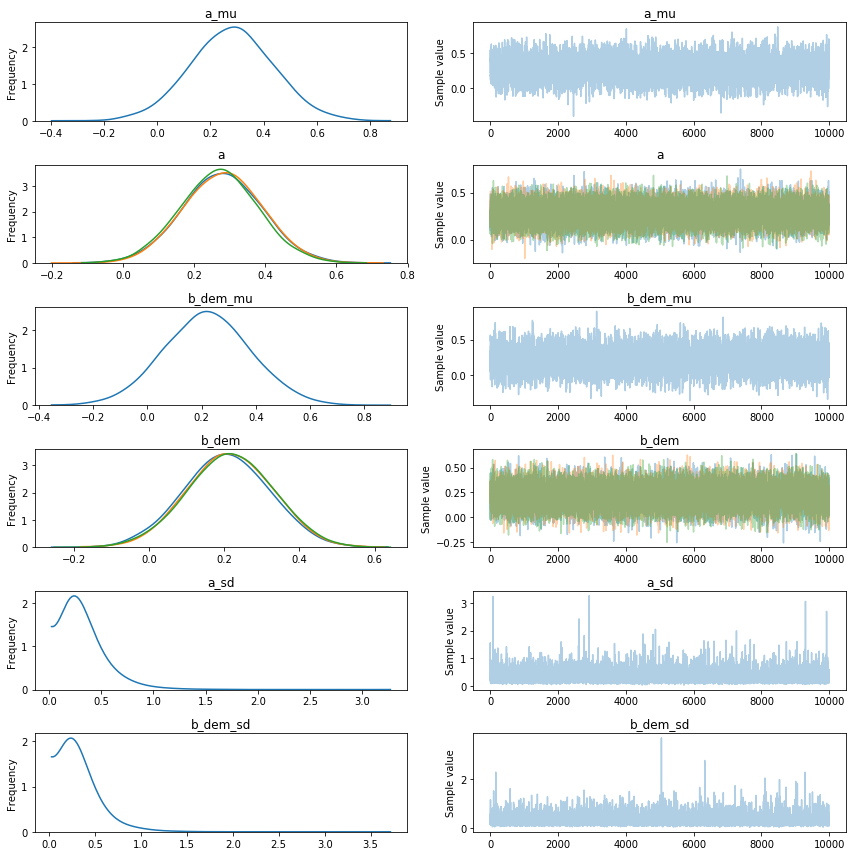

In [28]:
%matplotlib inline

import numpy as np
import pymc3 as pm
from sklearn.preprocessing import MinMaxScaler

data = state_legislature.loc[:, ['election_year','previous_dem_percent','adjusted_dropoff_ratio']]

model = pm.Model()

unique_years = data['election_year'].unique()
n_years = len(unique_years)
data['election_year_code'] = data['election_year'].apply(lambda x: np.where(unique_years == x)[0][0])
year_idx = data['election_year_code'].values

data['previous_dem_competitiveness'] = .25 - (0.5-data['previous_dem_percent'])**2

dem_scaler = MinMaxScaler()
dem_data = data.loc[:, ['previous_dem_competitiveness']].values
dem_data = dem_scaler.fit_transform(dem_data)

y_scaler = MinMaxScaler()
y_data = data.loc[:, ['adjusted_dropoff_ratio']].values
y_data = y_scaler.fit_transform(y_data)

year_idx_t = pm.Minibatch(year_idx, 250)
dem_data_t = pm.Minibatch(dem_data, 250)
y_data_t = pm.Minibatch(y_data, 250)

with model:
        a_mu = pm.Normal('a_mu', mu=0, sd=10)
        a_sd = pm.Lognormal('a_sd', mu=0, sd=1)
        a = pm.Normal('a', mu=a_mu, sd=a_sd, shape=n_years)

        b_dem_mu = pm.Normal('b_dem_mu', mu=0, sd=10)
        b_dem_sd = pm.Lognormal('b_dem_sd', mu=0, sd=1)
        b_dem = pm.Normal('b_dem', mu=b_dem_mu, sd=b_dem_sd, shape=n_years)
        
        lin = b_dem[year_idx_t]*dem_data_t.transpose() + a[year_idx_t]
        y = pm.Normal('y', mu=lin, sd=1, observed = y_data_t.transpose())
        
        inference = pm.ADVI()
        approx = pm.fit(n=100000, method=inference)
        trace = approx.sample(10000)
        
traceplot = pm.traceplot(trace)

### As stated above only 2014 showed enough evidence to confidently believe the previous_year's Dem competitiveness would generate a stronger performance ratio.

In [13]:
pm.summary(trace)

mean        sd  mc_error   hpd_2.5  hpd_97.5
a_mu      0.279825  0.151159  0.001588 -0.012402  0.577451
a__0      0.290549  0.108680  0.001065  0.085604  0.515648
a__1      0.277094  0.106046  0.001122  0.073617  0.488907
a__2      0.287223  0.108259  0.001089  0.071255  0.499992
b_dem_mu  0.204933  0.157741  0.001555 -0.104627  0.514165
b_dem__0  0.217570  0.114045  0.001247 -0.003005  0.443595
b_dem__1  0.223643  0.111933  0.001000  0.003625  0.439770
b_dem__2  0.213494  0.112850  0.001094 -0.013221  0.431541
a_sd      0.330818  0.210646  0.002087  0.056858  0.747194
b_dem_sd  0.333647  0.208589  0.002167  0.063214  0.743403

### From here one can build a more predictive model using public data. For example, in the scripts folder one can pull and load campaign finance report data to a database. Some interesting metrics from this data include:
* Number of contributions
* Average contribution
* Geography of contributions
* The amount spent and the types of things spent